<a href="https://colab.research.google.com/github/mazprimrez/MA4072-Pembelajaran-Mendalam-Deep-Learning-/blob/master/CNN_untuk_prediksi_harga_saham.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Model Convolutional Neural Network (CNN) untuk memprediksi harga saham ####

Biasanya model CNN digunakan untuk mengolah informasi terkait gambar. Kali ini agak pelik karena model CNN akan dipergunakan untuk memprediksi harga saham. 

Idenya datang dari data time series harga saham yang bisa diubah susunannya menjadi seperti data gambar yang berupa matriks. Data time series harga saham biasanya diambil pada saat **Close**, namun data time series harga saham masih dilengkapi dengan data-data lainnya, termasuk data time series harga saham pada saat **Open, Low, High** serta **Volume** transaksi. Bila masing-masing dari kelima data ini disusun seperti halnya sewaktu penyusunan data time series dengan **timesteps**, maka akan diperoleh matriks yang bisa diperlakukan seperti gambar sehingga bisa dipakai model CNN.

Selain kelima jenis data tadi, masih banyak lagi data time series harian yang berupa *technical indicators* untuk mendampingi *technical analysis* bagi para pemain saham. Data ini bisa dicari di internet, misalnya di https://www.alphavantage.co/. Data seperti itu bisa pula ditambahkan dan kelak setelah diolah sesuai dengan timesteps maka akan diperoleh matriks yang bisa diperlalukan seperti gambar.

Inilah ide dasar pengolahan model CNN untuk memprediksi harga saham. Hanya saja kali ini dibutuhkan variabel-variabel lain selain data tentang dirinya sendi. Kalau pemodelan time series harga saham dengan model MLP, RNN, LSTM maka hanya dibutuhkan data saham itu sendiri, tidak dibutuhkan data lainnya.

#### Data Preparation ####

>Berikut ini akan dibaca data harga saham BNI harian dari awal tahun 2003 
sampai akhir tahun 2019. Data dibaca dengan Pandas sebagai data frame.
Data dibersihkan dengan menghilangkan missing values dan data pada saat libur 
dengan jumlah volume transaksi sama dengan nol. Data dibersihkannya dengan Excel 
dan tetap disimpan lagi dalam format csv (column seperated values) agar 
mudah dibaca dengan Pandas.
>
> Data diambil dari Yahoo Finance: https://finance.yahoo.com/quote/BBNI.JK/history?p=BBNI.JK

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
%matplotlib inline

HargaSaham = pd.read_csv("/content/drive/My Drive/Colab Notebooks/BBNI 2003_2019 bersih.csv")

#Berikut ini contoh lima observasi pertama dari data harga saham BNI.
#Terlihat, isinya berupa harga saham ketika Open, High, Low dan Close 
#serta jumlah Volume perdagangan setiap hari. Jadi ada lima variables 
#(features) yang diambil dari Yahoo.

print('\nLima observasi pertama dari data df:')

HargaSaham.head()


Lima observasi pertama dari data df:


,Open,High,Low,Close,Volume
0,1232.400024,1327.199951,1232.400024,1232.400024,426687
1,1232.400024,1303.500000,1232.400024,1303.500000,159810
2,1303.500000,1303.500000,1232.400024,1232.400024,365506
3,1232.400024,1256.099976,1232.400024,1232.400024,71730
4,1232.400024,1256.099976,1232.400024,1232.400024,313290


In [ ]:
#Jumlah komponen baris dari data HargaSaham merupakan jumlah seluruh observasi 
#dari data: sebesar 3639 observasi
#Berikut dimensi data df

print('Dimensi dari data time series harga saham: ', HargaSaham.shape)

Dimensi dari data time series harga saham:  (3639, 5)


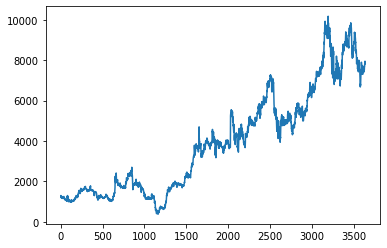

In [ ]:
#Model CNN akan dipergunakan untuk memodelkan harga saham pada saat Close:

y_close = HargaSaham['Close']

plt.plot(y_close)
plt.show()

Mula-mula setiap data time series yang akan dipergunakan di dalam pemodelan CNN akan diubah dulu menjadi data time series dengan nilai minimum 0 dan nilai maksimum 1. Ini tidak akan mempengaruhi pergerakan dinamik dari harga saham. Hal ini akan diperlihatkan dengan gambar di bawah.

Keuntungannya, bila data sudah ditransormasi maka kehadiran data yang berbeda-beda *unit of measurement*-nya seperti harga saham dan volume akan sangat menguntungkan sewaktu iterasi berjalan. Data yang sudah ditransformasi ini bisa membuat jangkauan perubahan parameternya sewaktu algoritma sedang berjalan tidak perlu terlalu lebar. Dengan demikian bisa dihemat waktu iterasinya. 

Bila data belum ditransformasi, ada parameter yang perlu berubah untuk mencapai nilai yang dituju nilainya mungkin kecil sekali. Namun bisa jadi ada parameter lain yang membutuhkan perubahan parameter untuk menuju nilai yang besar sekali. Ini karena adanya perbedaan unit of measurement itu dari kedua variabel tersebut.

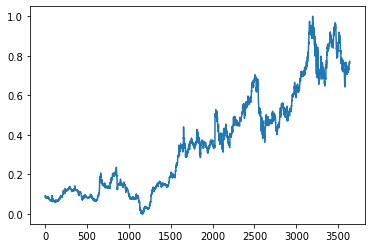

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))      #ditransformasi jadi di range 0-1 pake min-max
HargaSaham = scaler.fit_transform(HargaSaham)   #Jadi numpy array, tidak lagi pandas. Nah ini eksekusinya. Jadi fit nyimpen mu dan std terus transfrom ngitungnya

y_close = HargaSaham[:,3]

plt.plot(y_close)
plt.show()

> Sekalipun data time series dari harga saham sudah ditransformasi nilainya, pergerakan dinamiknya masih utuh seperti data harga saham aslinya, hanya beda skala (lihat satuan di sumbe tegak). Bandingkan gambar ini dengan gambar di atas.
>
> Jadi pada prinsipnya akan sama saja memodelkan harga saham dengan data aslinya atau dengan data yang telah ditransformasi. Hanya saja data time series yang sudah ditransformasi akan memudahkan iterasi untuk berjalan.
>
> Tentu saja setiap saat kita bisa memperoleh kembali data time series harga saham aslinya dari data harga saham yang telah ditransformasi melalui instuksi berikut

> **scaler.inverse_transform(df)**

Lima observasi pertama dari harga saham setelah ditransformasi telah kembali ke nilai aslinya:

[1232.400024 1232.400024 1232.400024 1232.400024 1232.400024] 



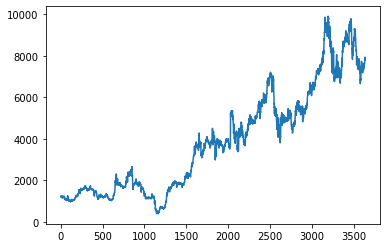

In [ ]:
HS = scaler.inverse_transform(HargaSaham)
y_close2 = HS[:,2]

#Bisa dilihat di bawah bahwa data harga saham aslinya segera bisa diperoleh 
#kembalidan gambar plot-nya juga masih sama.

print('Lima observasi pertama dari harga saham setelah ditransformasi telah kembali ke nilai aslinya:\n',)
print(y_close2[0:5],'\n')

plt.plot(y_close2)                  
plt.show()

Selanjutnya data akan dipisah menjadi dua: sebagian dipergunakan untukt training, sebagian yang lain tuntuk dipergunakan saat testing

In [ ]:
ntrain = 3000   #Sebanyak 3000 dari 3639 observasi akan digunakan untuk trianing
                #sisanya akan dipergunakan untuk testing

train = HargaSaham[0:ntrain]
test  = HargaSaham[ntrain:len(HargaSaham)]

y_close_train = y_close[0:ntrain]
y_close_test  = y_close[ntrain:len(y_close)]

In [ ]:
y_close_test.shape

(639,)

Berikut ini akan disusun serangkaian time series harga saham pada saat Open, High, Low, Close, serta Volume perdagangan untuk Bank BNI sesuai dengan _timesteps_ yang sudah kita pelajari sebelumnya. Hasil olahan data ini kelak akan dipakai untuk menyusun matriks data yang akan diperlakukan seperti data pixel untuk gambar. Inilah celah yang dipergunakan untuk memakai model CNN untuk data time series dengan penyertaan variabel-variabel lain yang relevan. 

Sebagai contoh, akan dipilih timesteps sebesar 10. Dari 5 variabels untuk harga saham Bank BNI yang sudah didownload tadi bisa diolah data time seriesnya sesuai dengan timestep yang kita pilih. Hasilnya, setiap variabel seolah telah memberikan tambahan 10 buah variabel baru. Akibatnya untuk setiap observari dari harga saham akan terbentuk matriks berukuran 10 X 5. Matriks ini bisa diperlakukan seperti sebuah gambar dan bisa dioleh dengan convolution.

Hanya saja pilihan filter (atau kernel) dari convolution-nya sangat terbatas agar tidak merusak struktur urutan waktu di data time series. Misalnya, pilihan filternya (kernelnya) bisa berupa (1,2) atau (1,3) atau (1,4) dan seterusnya. Ini artinya, filter hanya berjalan melalui tiap variabel pada observasi yang sama. 

In [ ]:
import numpy as np

def to_sequences(seq_size, data,close):
    x = []
    y = []

    for i in range(len(data)-seq_size-1):
        window = data[i:(i+seq_size)]
        after_window = close[i+seq_size]
        window = [[x] for x in window]
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)


timesteps = 10  #Setiap variabel akan menciptakan 10 variables (features) baru
                #Data akan berkurang sebayak 11 observasi

x_train, y_train = to_sequences(timesteps, train, y_close_train)
x_test, y_test   = to_sequences(timesteps, test, y_close_test)

print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (2989, 10, 1, 5)
Shape of x_test: (628, 10, 1, 5)
Shape of y_train: (2989,)
Shape of y_test: (628,)


Setelah data time series dioleh sesuai dengan timesteps, maka jumlah observasi untuk training dan testing jadi berubah. Masing-masing berkurang sebanyak 11 observasi. Data untuk trianing semula sebanyak 3000 observasi, kini menjadi 2989 observasi. Demikian pula data untuk testing yang semula 639 observasi kini menjadi 628 observasi.

In [ ]:
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[2], x_train.shape[1],x_train.shape[3]))
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[2],x_test.shape[1],x_test.shape[3]))

In [ ]:
print(x_train.shape)

(2989, 1, 10, 5)


Sampai tahap ini persiapan data sudah selesai. Data ini sudah siap dipakai untuk pemodelan CNN.

#### CNN Model  ###

Berikut ini akan digunakan aplikasi **Keras** untuk memodelkan harga saham Bank BNI 
dengan model CNN.


In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.optimizers import Adam
from keras.layers import Conv1D, Conv2D, MaxPooling2D
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import MinMaxScaler
import csv
import collections
from scipy.stats import zscore
from datetime import datetime
import matplotlib.pyplot as plt

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("physical_devices-------------", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Using TensorFlow backend.


physical_devices------------- 1


In [ ]:
#Untuk setiap observasi, mula-mula lakukan convolution pada matriks (10,5) 
#Pada contoh ini pada setiap observasi hanya dilakukan convolution sekali saja 
#dengan filter (kernel) berukuran (1,4). Hasilnya matriks data berukuran (10,2)

cnn = Sequential()
cnn.add(Conv2D(10, kernel_size = (1, 4), strides = (1, 1),  padding = 'valid', 
               activation = 'relu', input_shape = (1,10,5)))

#Pada setiap baris dari matriks (10,2) yang dihasilkan oleh convolution akan 
#dilih satu nilai yang terbesar sebagi wakilnya melalui penggunaan 
#MaxPooling dengan filter (1,2)
#Hasilnya berupa matriks (vektor) berukuran (10,1)

cnn.add(MaxPooling2D(pool_size = (1,2)))

#Matriks berukuran (10,1) hasil dari MaxPooling ini akan dipandang 
#sebagi input bagi hidden layer dengan 7 neurons

cnn.add(Flatten())
cnn.add(Dense(30, activation="relu"))

cnn.summary()   
cnn.add(Dense(1, activation="relu"))
cnn.summary()
    
# define optimizer and objective, compile cnn

cnn.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1, patience=2, verbose=2, mode='auto') 
checkpointer = ModelCheckpoint(filepath="CNN_Parameters_BNI.hdf5", verbose=0, save_best_only=True) # save best model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 7, 10)          210       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 3, 10)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
Total params: 1,140
Trainable params: 1,140
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 7, 10)          210       
______________________________

In [ ]:
tic = datetime.now()

cnn.fit(x_train,y_train,validation_split=0.001,callbacks=[checkpointer],verbose=0,epochs = 300)

toc = datetime.now()

print("Waktu yang diperlukan untuk menyelesaikan iterasi: ", toc-tic)

Waktu yang diperlukan untuk menyelesaikan iterasi:  0:01:20.257418


Hanya diperlukan waktu sekitar dua menit untuk menyelesaikan model CNN yang paling sederhana untuk data time series harga saham Bank BNI dengan 300 epochs.

In [ ]:
#Di atas tadi telah disimpan parameter dari model CNN dengan nama CNN_Parameters_BNI dalam
#format hdf5. Ketika Notebook ini dijalankan, maka akan tersimpan parameter 
#tersebut di folder yang sama. Sekarang dipanggil lagi utnuk melakukan prediksi.

cnn.load_weights('CNN_Parameters_BNI.hdf5')

pred = cnn.predict(x_test)
print("Shape: {}".format(pred.shape))
print(pred[0])

Shape: (628, 1)
[0.6246123]


In [ ]:
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(y_test, pred))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 0.03187712843061091


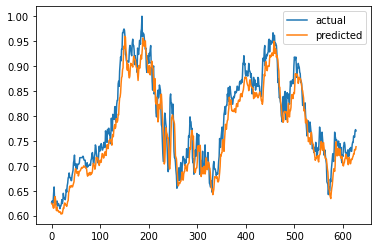

In [ ]:
plt.plot(y_test, label = 'actual')
plt.plot(pred,   label = 'predicted')
plt.legend()
plt.show()

Hasil prediksi ini diperoleh dari model CNN yang sangat minimalis. Hasilnya lumayan bukan? Pada prediksi kali ini *convolution* hanya dihitung sekali untuk setiap iterasi. Angka 1 di **cnn.add(Conv2D(1,...** mengindikasikan itu. Tentu saja angka ini bisa diganti-ganti. Ini merupakan hyperparameters yang boleh diganti-ganti.

Demikian pula pada layer bagian *fully connected network* hanya digunakan 7 buah neurons. Angka 7 di **cnn.add(Dense(7,...** mengindikasikan itu. Angka ini pun boleh diganti-ganti.

Setiap saat mulailah dari model yang paling sederhana dulu. Model boleh semakin rumit bila memang ada kebutuhannya.